# Gensim Topic Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Pyldavis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#### Color Palette

In [2]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar: {pospar.shape}')

Health: (30616, 7)
ObsGyn: (92943, 7)
Pospar: (49094, 7)


## Define Stop Words

In [4]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [5]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix From Corpus

#### Function

In [6]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document Term Matrix

In [7]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

In [8]:
def create_tdm(dtm):
    tdm = dtm.transpose()
    return tdm

In [9]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [10]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

In [11]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define Vocabulary Dictionary from Vectorizer

In [12]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [13]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

## Topic Modeling with Latent Dirichlet Allocation (LDA)

### Build LDA Models

#### Functions

In [14]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020)
    return lda

In [15]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [16]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

In [76]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def assign_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]): # iterate over transformed corpus to get topic probabilities for document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Dominant_Topic', 'Keywords', 'Original_Text']
    
    return sent_topics_df

#### General Women's Health Data
##### Grid Search to Find Optimal Number of Topics

##### Examine How Coherence Changes with the Number of Topics

##### Examine Topic Composition for Each Number of Topics

Because each model that was built in the grid search was stored in a model dictionary where the number of topics was the key, we can easily access the model to explore the topics that were created. 

For example, for the model with 6 topics, the following code can be used to retrieve the top 10 terms for each of the 6 topics.

```python
health_lda_6 = health_lda_models[6]

get_topic_terms(health_lda_6, 6, 10)
```
This was done for each several numbers of topics. At each step of the way, the topic clusters were evaluated to determine if the clusters made sense and if any loss in cohesion was offset by a gain in knowledge about a woman's health concern. After this process, 15 topics was determined to be the optimal number of topics for the general women's health data. Therefore, a new model was fit with the identified number of topics. To ensure, optimal allocation of topics, the model was allowed to run for 100 iterations. 

#### Build an LDA Model for General Women's Health Data and Evaluate on Coherence

In [56]:
health_lda_model = build_gensim_lda(health_corpus, 
                               n_topics = 12, 
                               vocabulary = health_vocabulary, 
                               n_passes = 50)

In [58]:
build_gensim_coherence_model(health_lda_model, corpus = health_corpus, dictionary = health_vocabulary)

-2.334

The LDA model with 12 topics has a coherence score of -2.3. Given that UMass coherence scores can range from 0 (best) to -14 (worst), this is a fairly good score and indicates that words within a topic are similar.

#### Explore Top Terms for Each Topic
**Note:** Top terms are determined based on their probability for occuring in the topic.

For each topic, we are able to view the terms with the highest probability of appearing in the topic. An example is shown in the cell below:

In [113]:
get_topic_terms(health_lda_model, 1, 5) # Will show the words with the highest probability for topic chosen at random

[(5,
  '0.098*"eat" + 0.051*"food" + 0.039*"self esteem" + 0.039*"esteem" + 0.035*"diet"')]

Above, we see a list containing a tuple. The first item in the tuple is the topic number, and the second item is a string that contains the probability of a word appearing in the topic and the word itself. I have chosen to display only the top five words

We can save a list of of the topics and top terms to a list (below), and use indexing to explore the topics and terms in this list. This exploration allows us to derive meaning from the topics. 

In [132]:
health_lda_topic_terms = get_topic_terms(health_lda_model, 12, 20)

In the table below, the twelve topics that were indentified in the General Women's Health data set are presented. As seen below, there were three topic clusters that were not related to women's health.


<h4 align = center> Clusters Related to Health Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
|:-:|:-:|:-:|
|0|Infections (Yeast Infection and Bacterial Vaginosis)|infection, yeast, yeast infection, discharge, smell|
|1|Feminine Hygiene Products| tampon, cup, pad, menstrual, menstrual cup|
|4| Pains| pain, period, cyst, cramp, doctor|
|5| Body Image and Self-Esteem| eat, food, self esteem, esteem, diet|
|6| Birth Control (Intrauterine Devices and Implants)| IUD (intrauterine device), control, birth, birth control, pill|
|7| General Gynecological Health| vagina, breast, sex, pap, hurt|
|8| Infections (Urinary Tract Infections)| UTI (urinary tract infection), pee, drink, antibiotic, orgasm|
|9| Birth Control (Oral Contraceptives and Condoms)| pill, birth control, birth, control, pack|
|10| Menstrual Cycle and Abnormalities| period, bleed, start, test, pregnancy|

<h4 align = center> Clusters Not Related to Health Concerns </h4>

| Cluster Number| Name| Top 5 Terms |
:-:|:-:|:-:
2| Social Relationships| friend, guy, people, work, thing
3| Hair and Depilation| hair, shave, skin, look, wax
11| Fashion| wear, dress, bra, look, buy




From this data set, the following women's health concerns emerged:

**Infections (Yeast Infections and Bacterial Vaginosis)**: The top five terms for this topic were "infection", "yeast", "yeast infection", "discharge", and "smell". However, other words that were seen in this topic cluster include mentions of "BV" (bacterial vaginosis), words related to anatomical location ("vagina", "vaginal"), and other vaginal symptoms ("itch", "itching", "symptom").

**Infections (Urinary Tract Infections)**: The top five terms for this topic were "UTI" (urinary tract infection), "pee", "drink", "antibiotic", and "orgasm". Other words related to urinary tract infections included descriptions of symptoms: "burn", "urine", "bladder", "sensation". The words "sex" and "orgasm" were also included in this cluster. Given that sexual intercourse can be a source of bacteria that might lead to a urinary tract infection, it is possible that these terms were included in posts as a possible cause of the infection.

**Menstrual Cycle and Abnormalities**: The top five terms for this topic were "period", "bleed", "start", "test" and "pregnancy". Words such as "period", "bleed", "start", "normal", "cycle", and "blood" suggest that the topic is about the menstrual cycle. Words such as "test", "pregnancy", "pregnant", "late", "spot", "pill", and "light" suggest that this topic might describe menstrual cycle abnormalities, such as a late or missed period, possibility of pregnancy, spotting, or a lighter than usual period.

**Feminine Hygiene Products**: The top five words for this topic were "tampon", "cup", "pad", "menstrual", and "menstrual cup". All of these words are commonly used feminine hygiene products used during a woman's period. Additionally, words that suggest advice on how or when to use these products emerged, including "use", "try", "insert", and "wear". Events which might require a feminine hygiene product also emerged, including "abortion" and "period".

**General Gynecological Health**: The top five words for this topic were "vagina", "breast", "sex", "pap" (pap smear), and "hurt". This cluster contained words related to the routine gynecological exam, including "pap", "smear", "pap smear", and "doctor". This topic also seemed to capture concerns about possible tumors ("lump", "bump") and general pains ("hurt", "pain", "painful"). All of the concerns in this topic are things that would be discussed at an annual gynecological exam.

**Pains**: The top five words for this topic were "pain", "period", "cyst", "cramp", "doctor". This topic seemed to capture common pains that women experience, including period pain ("period", "cramp", "pelvic"), as well as pains related to ovarian cysts ("ovary", "ovarian", "cyst", "pelvic", "right"). The term "ultrasound" suggests that this topic might also include procedures used to detect ovarian cysts.

**Birth Control (Intrauterine Devices and Implants)**: The top five words for this topic were "IUD" (intrauterine device), "control", "birth", "birth control", an "pill". Although the posts in this topic were likely related to birth control, several words suggest that the questions were about alternatives to oral contraceptives. The words "implant" and "Nexplanon" (a type of implant) suggest birth control implants, while the words "IUD", "Mirena" (a brand of IUD), "copper", and "hormonal" could be discussing hormonal and non-hormonal versions of IUDs. It appears that this topic might also include posts about experiences with these birth control methods, including possible effects on "acne" and "mood".

**Birth Control (Oral Contraceptives and Condoms)**: The top five words for this topic were "pill", "birth control", "birth", "control", and "pack". Several of these words, including the top five, suggest that this topic includes posts about oral contraceptives. Other words that suggest oral contraceptives are "control pill", "plan" (maybe Plan B), "placebo", "bc" (birth control), and "miss" (possibly a missed pill). "Condom" is also the 6th most common word, which suggests that condoms as a form of birth control might also be included in this topic.

**Body Image and Self-Esteem**: The top five words for this category were "eat", "food", "self esteem", "esteem", and "diet". Several words suggest that this topic might include posts about body image and self-esteem, including "eat", "food", "self esteem", "esteem", "diet", "vitamin", "belly", "insecure", "supplement", and "cope". 

#### Explore How Topics Relate to Original Data

For each post in our data set, we are able to assign it to a topic. Each post was assigned to the topic with the highest probability.

##### Rename Topic Numbers and Assign Topics

In [164]:
health_topic_df = assign_topics_sentences(health_lda_model, health_corpus, health['total_text'])

In [183]:
health_topic_df['Dominant_Topic'] = health_topic_df['Dominant_Topic'].map({0.0: 'Infections (Yeast Infection and Bacterial Vaginosis)',
                                                    1.0: 'Feminine Hygiene Products',
                                                    2.0: 'Social Relationships',
                                                    3.0: 'Hair and Depilation',
                                                    4.0: 'Pains',
                                                    5.0: 'Body Image and Self-Esteem',
                                                    6.0: 'Birth Control (Intrauterine Devices and Implants',
                                                    7.0: 'General Gynecological Health',
                                                    8.0: 'Infections (Urinary Tract Infections)',
                                                    9.0: 'Birth Control (Oral Contraceptives and Condoms)',
                                                    10.0: 'Menstrual Cycle and Abnormalities',
                                                    11.0: 'Fashion'})

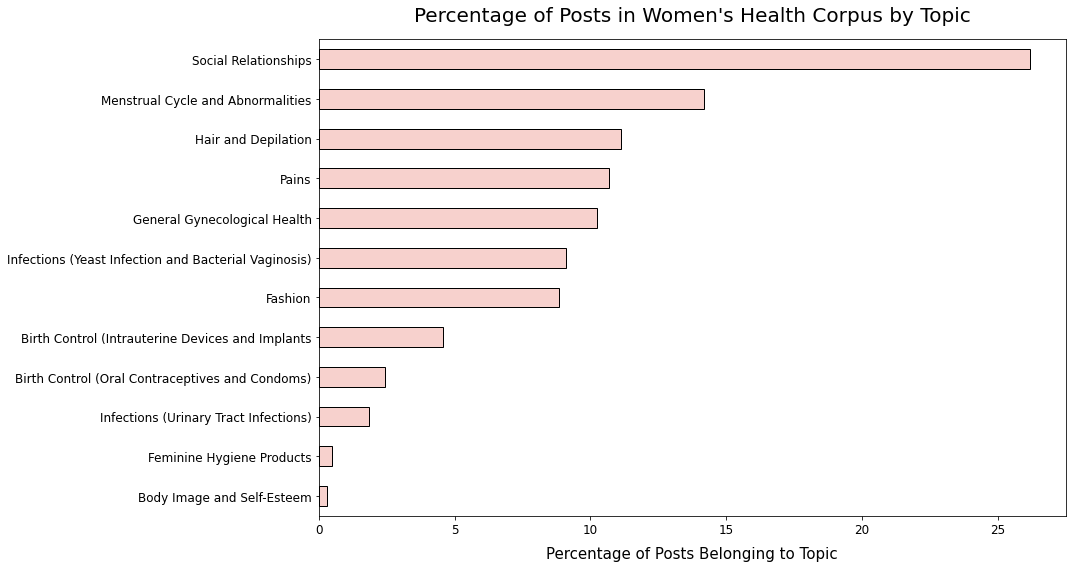

In [191]:
plt.figure(figsize = (15, 8))
round(health_topic_df['Dominant_Topic'].value_counts(normalize = True) * 100, 2).sort_values(ascending = True).plot.barh(color = blush, ec = 'k');
plt.title('Percentage of Posts in Women\'s Health Corpus by Topic', fontdict = {'fontsize': 20}, pad = 18)
plt.xlabel('Percentage of Posts Belonging to Topic', fontdict = {'fontsize': 15}, labelpad = 10)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.tight_layout();

#### Fertility and Pregnancy

In [28]:
obsgyn_lda_model = build_gensim_lda(obsgyn_corpus, 
                               n_topics = 16, 
                               vocabulary = obsgyn_vocabulary, 
                               n_passes = 50)

In [29]:
get_topic_terms(obsgyn_lda_model, 16, 10)

[(0,
  '0.011*"baby" + 0.009*"pregnant" + 0.009*"tell" + 0.008*"work" + 0.007*"family" + 0.007*"husband" + 0.006*"people" + 0.006*"friend" + 0.006*"pregnancy" + 0.005*"mom"'),
 (1,
  '0.016*"labor" + 0.013*"contraction" + 0.011*"birth" + 0.011*"baby" + 0.010*"hospital" + 0.008*"induce" + 0.008*"induction" + 0.008*"epidural" + 0.008*"hour" + 0.007*"csection"'),
 (2,
  '0.034*"try" + 0.024*"ttc" + 0.020*"conceive" + 0.019*"fertility" + 0.014*"cycle" + 0.014*"pregnant" + 0.013*"start" + 0.013*"iui" + 0.013*"sperm" + 0.013*"ivf"'),
 (3,
  '0.096*"test" + 0.051*"positive" + 0.039*"pregnancy" + 0.035*"pregnancy test" + 0.031*"negative" + 0.025*"line" + 0.021*"hcg" + 0.019*"faint" + 0.019*"dpo" + 0.018*"early"'),
 (4,
  '0.031*"period" + 0.013*"pregnant" + 0.013*"sex" + 0.012*"test" + 0.011*"bleed" + 0.010*"cramp" + 0.010*"spot" + 0.009*"pregnancy" + 0.009*"symptom" + 0.008*"start"'),
 (5,
  '0.035*"cycle" + 0.027*"ovulation" + 0.024*"opk" + 0.021*"cd" + 0.020*"ovulate" + 0.015*"test" + 0.014

In [30]:
build_gensim_coherence_model(obsgyn_lda_model, corpus = obsgyn_corpus, dictionary = obsgyn_vocabulary)

-2.27

In [31]:
# pickle.dump(obsgyn_lda_model, open('../pickles/obsgyn_lda_model.p', 'wb'))

#### Postpartum Data

In [45]:
pospar_lda_model = build_gensim_lda(pospar_corpus, 
                               n_topics = 12, 
                               vocabulary = pospar_vocabulary, 
                               n_passes = 50)

In [60]:
get_topic_terms(pospar_lda_model, 12, 5)

[(0,
  '0.013*"ultrasound" + 0.013*"weight" + 0.011*"doctor" + 0.010*"baby" + 0.010*"test"'),
 (1,
  '0.020*"sleep" + 0.017*"nurse" + 0.016*"night" + 0.016*"feed" + 0.015*"old"'),
 (2,
  '0.016*"labor" + 0.014*"contraction" + 0.009*"birth" + 0.009*"baby" + 0.008*"hospital"'),
 (3,
  '0.020*"pain" + 0.014*"belly" + 0.008*"kick" + 0.008*"baby" + 0.008*"seat"'),
 (4,
  '0.024*"period" + 0.021*"test" + 0.017*"pregnancy" + 0.016*"pregnant" + 0.011*"symptom"'),
 (5,
  '0.036*"pump" + 0.023*"bra" + 0.014*"bag" + 0.014*"spectra" + 0.013*"breast"'),
 (6,
  '0.018*"baby" + 0.016*"buy" + 0.015*"clothe" + 0.014*"nursery" + 0.012*"diaper"'),
 (7,
  '0.012*"baby" + 0.011*"work" + 0.009*"shower" + 0.008*"family" + 0.008*"leave"'),
 (8,
  '0.020*"eat" + 0.014*"food" + 0.011*"nausea" + 0.011*"pregnancy" + 0.010*"sickness"'),
 (9,
  '0.025*"pump" + 0.019*"milk" + 0.013*"supply" + 0.013*"breast" + 0.012*"feed"'),
 (10,
  '0.039*"boy" + 0.034*"girl" + 0.034*"gender" + 0.026*"baby" + 0.019*"group"'),
 (11,

In [47]:
build_gensim_coherence_model(pospar_lda_model, corpus = pospar_corpus, dictionary = pospar_vocabulary)

-2.005

In [36]:
# pickle.dump(pospar_lda_model, open('../pickles/pospar_lda_model.p', 'wb'))

## Visualize Topics with pyLDAvis

In [87]:
 from IPython.core.display import HTML


### Create Gensim Dictionary

In [37]:
# https://stackoverflow.com/questions/21552518/using-scikit-learn-vectorizers-and-vocabularies-with-gensim

health_gensim_dict = Dictionary.from_corpus(corpus = health_corpus, id2word = health_vocabulary)
obsgyn_gensim_dict = Dictionary.from_corpus(corpus = obsgyn_corpus, id2word = obsgyn_vocabulary)
pospar_gensim_dict = Dictionary.from_corpus(corpus = pospar_corpus, id2word = pospar_vocabulary)

In [90]:
health_prepared = pyLDAvis.gensim.prepare(health_lda_model, health_corpus, health_gensim_dict)
health_display = pyLDAvis.display(health_prepared)
health_display

In [40]:
pyLDAvis.gensim.prepare(obsgyn_lda_model, obsgyn_corpus, obsgyn_gensim_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004583  0.107485       1        1  21.629931
1     -0.008405  0.084010       2        1  10.371261
9     -0.068894  0.018633       3        1   9.605941
12    -0.000010  0.078700       4        1   8.080772
11    -0.009496  0.065960       5        1   7.940592
4     -0.123895 -0.062639       6        1   6.984771
13     0.119819  0.078064       7        1   6.625446
5     -0.151034 -0.092969       8        1   5.220362
14    -0.007064  0.100422       9        1   4.125914
15     0.080242  0.043301      10        1   3.588799
2     -0.091694 -0.012218      11        1   3.464478
8      0.007222  0.123634      12        1   3.000629
10     0.014361  0.012140      13        1   2.923506
3     -0.239684 -0.227084      14        1   2.527922
6      0.189077 -0.021056      15        1   2.274495
7      0.284872 -0.296383      16        1   1.635181, topic_info=           Term         Freq        Total Category  logprob  loglift
40         test  2336.000000  2336.000000  Default  30.0000  30.0000
477       sleep  1291.000000  1291.000000  Default  29.0000  29.0000
86     positive  1235.000000  1235.000000  Default  28.0000  28.0000
71    pregnancy  3137.000000  3137.000000  Default  27.0000  27.0000
35        cycle  1319.000000  1319.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
180        look   122.816195  1709.305113  Topic16  -4.0755   1.4803
373       small    73.376520   611.978298  Topic16  -4.5906   1.9923
1221     breast    71.448199   584.650098  Topic16  -4.6172   2.0114
3           buy    70.153336   750.918051  Topic16  -4.6355   1.7428
275       short    65.801415   448.100167  Topic16  -4.6995   2.1950

[815 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1080      2  0.101601   abdoman
1080      3  0.081281   abdoman
1080      5  0.690890   abdoman
1080      6  0.111762   abdoman
1409      1  0.833625  abortion
...     ...       ...       ...
1457      3  0.016263      yoga
1457      4  0.073183      yoga
1457      5  0.252073      yoga
1457      7  0.048788      yoga
1457     10  0.406570      yoga

[5068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 10, 13, 12, 5, 14, 6, 15, 16, 3, 9, 11, 4, 7, 8])

In [48]:
pyLDAvis.gensim.prepare(pospar_lda_model, pospar_corpus, pospar_gensim_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.039401  0.127348       1        1  17.007805
11    -0.009919 -0.039763       2        1  16.426525
2     -0.087163 -0.036334       3        1  10.829593
7      0.073413 -0.027530       4        1   9.714262
1     -0.061936  0.123061       5        1   8.704451
0     -0.064562 -0.093156       6        1   7.869842
4     -0.100617 -0.105681       7        1   5.909942
3     -0.096029  0.021868       8        1   5.692715
8     -0.118282  0.032226       9        1   5.551048
6      0.152358  0.084127      10        1   5.472719
5      0.184079  0.126519      11        1   4.106664
10     0.168059 -0.212685      12        1   2.714436, topic_info=         Term         Freq        Total Category  logprob  loglift
41       pump  1453.000000  1453.000000  Default  30.0000  30.0000
273       boy   432.000000   432.000000  Default  29.0000  29.0000
154      girl   478.000000   478.000000  Default  28.0000  28.0000
73       feed   903.000000   903.000000  Default  27.0000  27.0000
69       milk   995.000000   995.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
275      wife    44.595115   278.899063  Topic12  -5.0041   1.7734
316     happy    46.162901   358.850044  Topic12  -4.9695   1.5559
63        mom    48.361064   705.333159  Topic12  -4.9230   0.9266
12   pregnant    47.398076  1173.476989  Topic12  -4.9431   0.3974
42       look    42.682855   879.162356  Topic12  -5.0479   0.5814

[710 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1194      1  0.017641  accurate
1194      6  0.405742  accurate
1194      7  0.141128  accurate
1194     11  0.035282  accurate
1194     12  0.370460  accurate
...     ...       ...       ...
380       5  0.017219      yoga
380       6  0.034437      yoga
380       8  0.533776      yoga
380       9  0.086093      yoga
380      10  0.068874      yoga

[3673 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 12, 3, 8, 2, 1, 5, 4, 9, 7, 6, 11])